In [3]:
import yfinance as yf
import pandas as pd
from riskparityportfolio import RiskParityPortfolio
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pyfolio as pf

In [9]:
crypto = ['BTC-USD', 'ETH-USD', 'LTC-USD', 'XRP-USD', 'BCH-USD', 'BNB-USD', 'EOS-USD', 'XLM-USD', 'ADA-USD', 'TRX-USD', 'SOL-USD', 'AVAX-USD']

df = pd.DataFrame()
for coin in crypto:
    data = yf.download(coin, start="2018-01-01", end="2024-01-01")['Adj Close']
    df[coin] = data
    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta inst

In [10]:
df.dropna(inplace=True)
df.head()

,BTC-USD,ETH-USD,LTC-USD,XRP-USD,BCH-USD,BNB-USD,EOS-USD,XLM-USD,ADA-USD,TRX-USD,SOL-USD,AVAX-USD
Date,,,,,,,,,,,,
2020-07-13,9243.614258,239.604584,43.919796,0.198575,232.428650,18.409563,2.554170,0.090291,0.124156,0.017553,1.175734,4.896294
2020-07-14,9243.213867,240.211487,43.802864,0.198809,230.007889,18.082909,2.556810,0.092108,0.131963,0.017641,1.148075,4.986754
2020-09-22,10538.459961,344.503174,44.545048,0.233417,220.034225,24.100740,2.573652,0.071987,0.081754,0.025044,2.915519,5.234632
2020-09-23,10246.186523,321.116302,43.057690,0.221221,207.917099,22.856977,2.449291,0.067574,0.076763,0.024859,2.836757,4.118469
2020-09-24,10760.066406,349.355591,45.039856,0.232905,216.387589,24.613825,2.540026,0.070370,0.082817,0.026193,3.132715,4.566561


In [11]:
df_log = np.log(df/df.shift(1))
df_log.dropna(inplace=True)

In [12]:
df_lin = df.pct_change()
df_lin.dropna(inplace=True)

In [13]:
cutoff = round(0.7*df_log.shape[0])
X_train_log = df_log.iloc[:cutoff]
X_test_log = df_log.iloc[cutoff:]
X_train_lin = df_lin.iloc[:cutoff]
X_test_lin = df_lin.iloc[cutoff:]

In [14]:
mu = df_log.mean()
Sigma = df_log.cov()

In [15]:
mu = np.array(mu)

In [16]:
print(Sigma.shape)
print(mu.shape)

(12, 12)
(12,)


In [17]:
def portfolio_markowitz(mu, Sigma, lmd = 0.5):
    w = cp.Variable(len(Sigma))
    objective = cp.Maximize(mu.T @ w - lmd * cp.quad_form(w, Sigma))
    constraints = [w >= 0, cp.sum(w) == 1]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return w.value

def portfolio_gmvp(Sigma):
    w = cp.Variable(len(Sigma))
    objective = cp.Minimize(cp.quad_form(w, Sigma))
    constraints = [w >= 0, cp.sum(w) == 1]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return w.value

w_markowitz = portfolio_markowitz(mu, Sigma)
w_gmvp = portfolio_gmvp(Sigma)

## Lack of diversification

          GMVP  Markowitz
BTC-USD   0.87      -0.00
ETH-USD  -0.00      -0.00
LTC-USD  -0.00      -0.00
XRP-USD   0.00      -0.00
BCH-USD  -0.00      -0.00
BNB-USD  -0.00       0.54
EOS-USD   0.00       0.00
XLM-USD   0.00      -0.00
ADA-USD   0.00      -0.00
TRX-USD   0.13      -0.00
SOL-USD  -0.00       0.46
AVAX-USD -0.00      -0.00


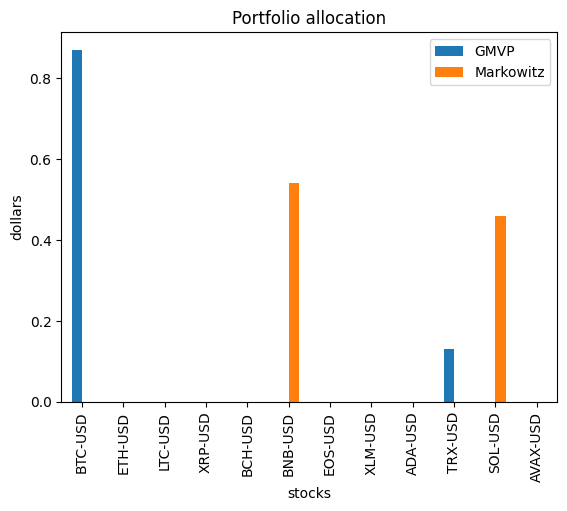

In [18]:

# put together all portfolios
w_all = pd.DataFrame({'GMVP': w_gmvp, 'Markowitz': w_markowitz}, index=crypto)
w_all = w_all.round(2)

print(w_all)

# plot
w_all.plot(kind='bar', stacked=False)
plt.title('Portfolio allocation')
plt.xlabel('stocks')
plt.ylabel('dollars')
plt.legend(w_all.columns)
plt.show()

In [19]:


# compute returns of all portfolios
ret_all = df_log.dot(w_all)

# split into training and test sets
T_trn = int(len(ret_all) * 0.8)  
ret_all_trn = ret_all.iloc[:T_trn]
ret_all_tst = ret_all.iloc[T_trn:]

# performance
perf_stats_func = pf.timeseries.perf_stats  # shortcut for performance stats function
sharpe_ratio_func = pf.timeseries.sharpe_ratio  # shortcut for Sharpe ratio function

print("Training set performance:")
print(perf_stats_func(returns=ret_all_trn['GMVP']))
print("Sharpe Ratio:", sharpe_ratio_func(returns=ret_all_trn['GMVP'], risk_free=0))

print("Test set performance:")
print(perf_stats_func(returns=ret_all_tst['GMVP']))
print("Sharpe Ratio:", sharpe_ratio_func(returns=ret_all_tst['GMVP'], risk_free=0))

Training set performance:
Annual return          0.159258
Cumulative returns     0.752796
Annual volatility      0.573850
Sharpe ratio           0.547105
Calmar ratio           0.191482
Stability              0.306209
Max drawdown          -0.831714
Omega ratio            1.104350
Sortino ratio          0.772465
Skew                  -0.304456
Kurtosis               3.358771
Tail ratio             1.030057
Daily value at risk   -0.071052
dtype: float64
Sharpe Ratio: 0.5471053361976123
Test set performance:
Annual return          0.404445
Cumulative returns     0.381913
Annual volatility      0.299315
Sharpe ratio           1.283739
Calmar ratio           2.141524
Stability              0.547544
Max drawdown          -0.188859
Omega ratio            1.270459
Sortino ratio          2.024721
Skew                   0.381130
Kurtosis               3.041805
Tail ratio             1.227901
Daily value at risk   -0.036185
dtype: float64
Sharpe Ratio: 1.2837385249292352


/var/folders/zs/0__x1xy535v4hs2w9q1vy03c0000gn/T/ipykernel_74622/359281503.py:15: DeprecationWarning: Risk functions in pyfolio.timeseries are deprecated and will be removed in a future release. Please install the empyrical package instead.
  print("Sharpe Ratio:", sharpe_ratio_func(returns=ret_all_trn['GMVP'], risk_free=0))
/var/folders/zs/0__x1xy535v4hs2w9q1vy03c0000gn/T/ipykernel_74622/359281503.py:19: DeprecationWarning: Risk functions in pyfolio.timeseries are deprecated and will be removed in a future release. Please install the empyrical package instead.
  print("Sharpe Ratio:", sharpe_ratio_func(returns=ret_all_tst['GMVP'], risk_free=0))


In [20]:
print("Training set performance:")
print(perf_stats_func(returns=ret_all_trn['Markowitz']))
print("Sharpe Ratio:", sharpe_ratio_func(returns=ret_all_trn['Markowitz'], risk_free=0))

print("Test set performance:")
print(perf_stats_func(returns=ret_all_tst['Markowitz']))
print("Sharpe Ratio:", sharpe_ratio_func(returns=ret_all_tst['Markowitz'], risk_free=0))

Training set performance:
Annual return           0.396003
Cumulative returns      2.549956
Annual volatility       0.930471
Sharpe ratio            0.825763
Calmar ratio            0.430383
Stability               0.000014
Max drawdown           -0.920118
Omega ratio             1.171239
Sortino ratio           1.240960
Skew                    0.615335
Kurtosis               17.294697
Tail ratio              1.140364
Daily value at risk    -0.114179
dtype: float64
Sharpe Ratio: 0.8257632915577382
Test set performance:
Annual return          0.802101
Cumulative returns     0.752262
Annual volatility      0.460331
Sharpe ratio           1.509802
Calmar ratio           2.378744
Stability              0.351702
Max drawdown          -0.337195
Omega ratio            1.306524
Sortino ratio          2.324456
Skew                   0.033962
Kurtosis               2.357382
Tail ratio             1.343703
Daily value at risk   -0.055238
dtype: float64
Sharpe Ratio: 1.5098017831415675


/var/folders/zs/0__x1xy535v4hs2w9q1vy03c0000gn/T/ipykernel_74622/1646929414.py:3: DeprecationWarning: Risk functions in pyfolio.timeseries are deprecated and will be removed in a future release. Please install the empyrical package instead.
  print("Sharpe Ratio:", sharpe_ratio_func(returns=ret_all_trn['Markowitz'], risk_free=0))
/var/folders/zs/0__x1xy535v4hs2w9q1vy03c0000gn/T/ipykernel_74622/1646929414.py:7: DeprecationWarning: Risk functions in pyfolio.timeseries are deprecated and will be removed in a future release. Please install the empyrical package instead.
  print("Sharpe Ratio:", sharpe_ratio_func(returns=ret_all_tst['Markowitz'], risk_free=0))


In [21]:
# calculate cumulative returns
cum_ret_trn = (1 + ret_all_trn).cumprod() - 1
cum_ret_tst = (1 + ret_all_tst).cumprod() * (1 + cum_ret_trn.iloc[-1]) - 1

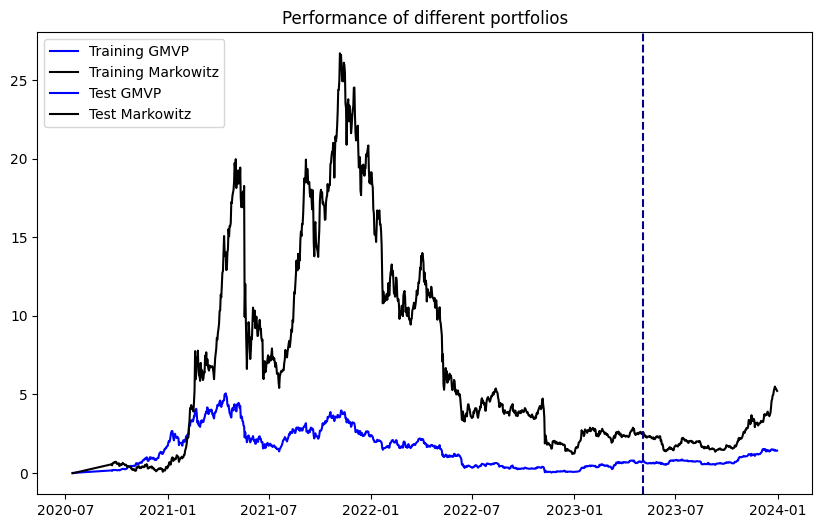

In [22]:
# plot
plt.figure(figsize=(10, 6))

# define colors for each portfolio
colors = {'GMVP': 'blue', 'Markowitz': 'black'}

# plot each portfolio in the training set
for portfolio in cum_ret_trn.columns:
    plt.plot(cum_ret_trn[portfolio], label=f'Training {portfolio}', color=colors[portfolio])

# plot each portfolio in the test set
for portfolio in cum_ret_tst.columns:
    plt.plot(cum_ret_tst[portfolio], label=f'Test {portfolio}', color=colors[portfolio])

plt.axvline(x=cum_ret_trn.index[-1], color='darkblue', linestyle='--')
plt.title('Performance of different portfolios')
plt.legend(loc='upper left')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


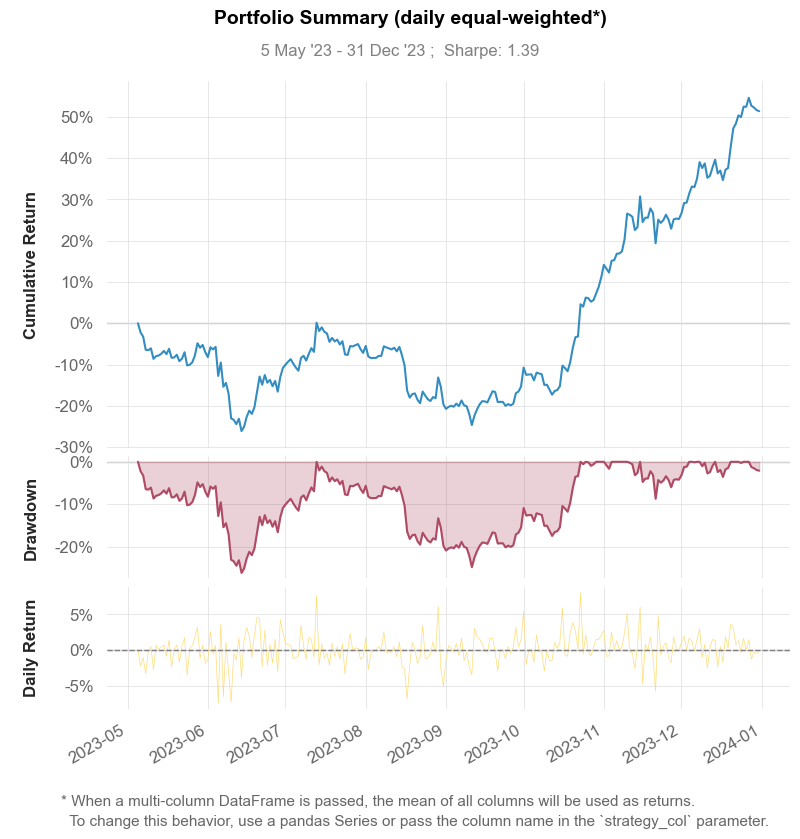

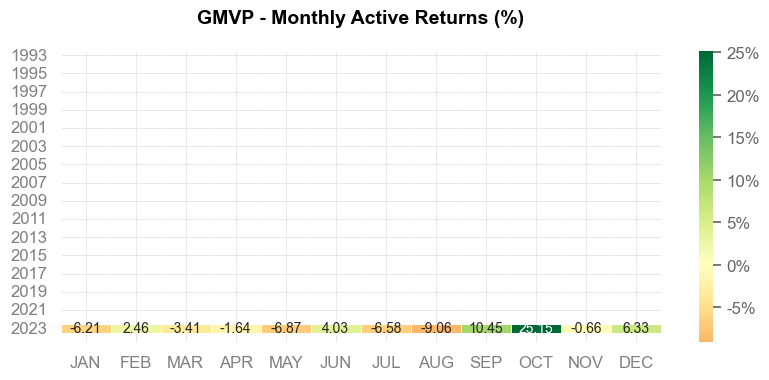

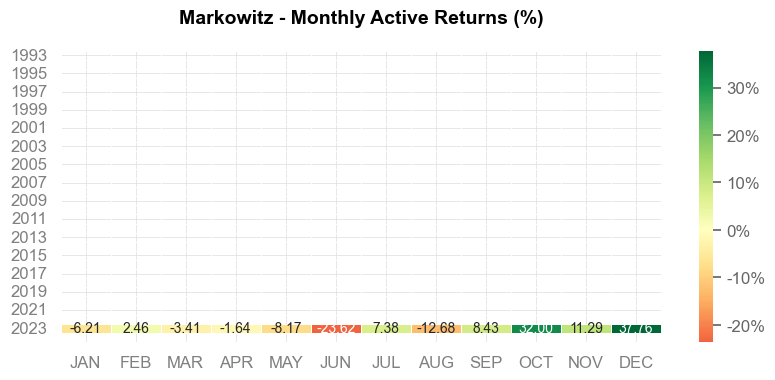

In [23]:
import quantstats as qs

spy = qs.utils.download_returns('SPY')

qs.reports.plots(ret_all_tst.dropna(), benchmark=spy, compounded=False)


## Risk Parity Portfolio

In [24]:
rpp = RiskParityPortfolio(Sigma)
w = rpp.weights
risk_contribution = rpp.risk_contributions

print(w)
print(risk_contribution)

# calculate portfolio risk contributions manually
manual_risk_contribution = np.dot(w, np.dot(Sigma, w))
print(manual_risk_contribution)

w_series = pd.Series(w, index=Sigma.index, name='risk-parity')
# add weights to DataFrame
w_all = pd.concat([w_all, w_series], axis=1)

[0.12176695 0.08824398 0.08129886 0.07385546 0.07995868 0.08835664
 0.07196568 0.07900539 0.08293947 0.09621567 0.06824675 0.06814645]
[0.08324739 0.08328319 0.08329347 0.08331006 0.08331126 0.08337286
 0.08337732 0.08338586 0.08340974 0.08339498 0.08335546 0.08325841]
0.001718251266501229


In [25]:
w_all

,GMVP,Markowitz,risk-parity
BTC-USD,0.87,-0.00,0.121767
ETH-USD,-0.00,-0.00,0.088244
LTC-USD,-0.00,-0.00,0.081299
XRP-USD,0.00,-0.00,0.073855
BCH-USD,-0.00,-0.00,0.079959
BNB-USD,-0.00,0.54,0.088357
EOS-USD,0.00,0.00,0.071966
XLM-USD,0.00,-0.00,0.079005
ADA-USD,0.00,-0.00,0.082939
TRX-USD,0.13,-0.00,0.096216


In [26]:
w_all.dropna(inplace=True)

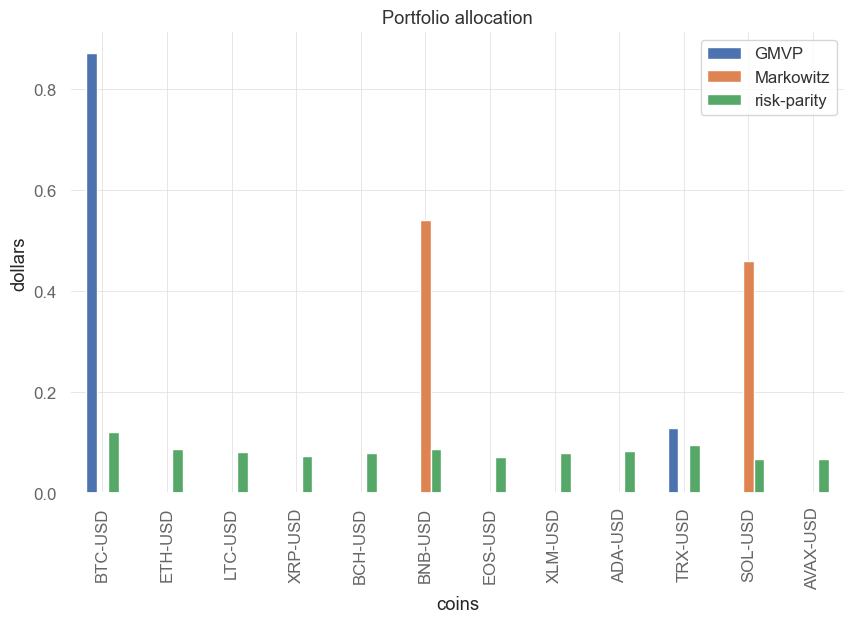

In [27]:
w_all.plot(kind='bar', stacked=False)
plt.title('Portfolio allocation')
plt.xlabel('coins')
plt.ylabel('dollars')
plt.legend(w_all.columns)
plt.show()

In [28]:

# compute returns of all portfolios
ret_rpp = df_log.dot(w_series)

# split into training and test sets
trn = int(len(ret_rpp) * 0.8)  
ret_rpp_trn = ret_rpp.iloc[:trn]
ret_rpp_tst = ret_rpp.iloc[trn:]

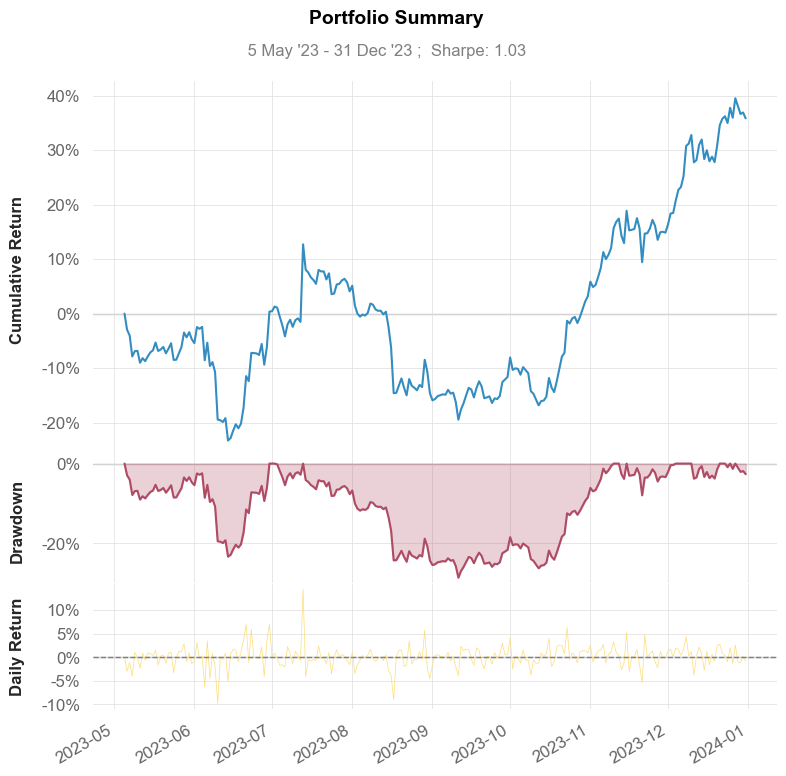

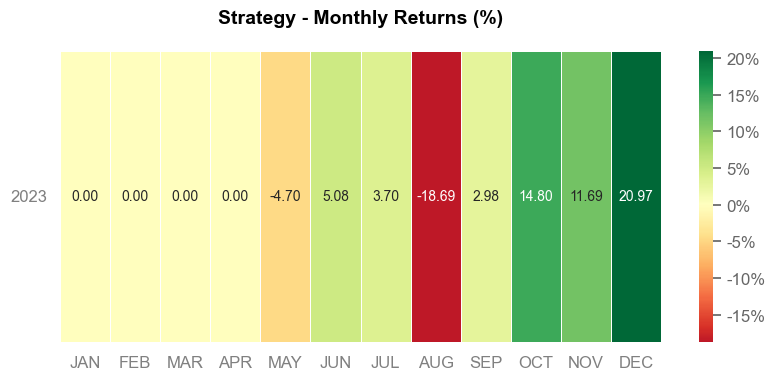

In [29]:
qs.reports.plots(ret_rpp_tst.dropna(), compounded=False)

The risk-parity portfolio precisely aims at diversifying the risk contribution and it also happens to be less sensitive to the parameters.